In [3]:
#!pip install -q -U transformers 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import json
import shutil
import os
from datetime import datetime
from glob import glob
import torch.nn.functional as F

/Users/christopherackerman/repos/activation_additions_hf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Model wrapper to handle activation reading/adding
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block):
        super().__init__()
        self.block = block
        self.last_hidden_state = None
        self.add_activations = None

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        self.last_hidden_state = output[0]#activation
        if self.add_activations is not None:
            print(f"Output shape={output[0].shape}, activation shape={self.add_activations.shape}")
            print("Initial output:", output[0][:, -1, :5])  # Debug: Print first few elements of the output tensor
            output = (output[0] + self.add_activations,) + output[1:]#reconstruct output (with whatever other junk they throw in there, if any) with modified activations
            ###print("Modified output:", output[0][:, :5])  # Debug: Print first few elements of the modified output tensor
        return output

    def add(self, activations):
        self.add_activations = activations
        ###print("Activations set:", activations[:5])

    def reset(self):
        self.last_hidden_state = None
        self.add_activations = None
        
class StopAtTokenCriteria(StoppingCriteria):
    def __init__(self, stop_token_id):
        self.stop_token_id = stop_token_id
    
    def __call__(self, input_ids, scores):
        # Check if the last generated token is the stop token
        return input_ids[0, -1] == self.stop_token_id
    
class GPT2Helper:
    def __init__(self, pretrained_model="gpt2", device="cpu"):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.model = AutoModelForCausalLM.from_pretrained(pretrained_model).to(self.device)
        for i, layer in enumerate(self.model.transformer.h):
            self.model.transformer.h[i] = BlockOutputWrapper(layer)

    def generate(self, inputs, **sampling_kwargs):
        return self.model.generate(**inputs, **sampling_kwargs)

    def generate_text(self, prompt, max_length=100, stop_token=""):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        attention_mask = inputs['attention_mask']
        generate_ids = self.model.generate(
            inputs.input_ids.to(self.device), 
            attention_mask=attention_mask.to(self.device), 
            max_length=max_length
            ,pad_token_id=self.tokenizer.eos_token_id
            ,stopping_criteria=[StopAtTokenCriteria(self.tokenizer.convert_tokens_to_ids(stop_token))] if stop_token else []
        )
        return self.tokenizer.decode(generate_ids[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    def get_logits(self, tokens):
        with torch.no_grad():
            outputs = self.model(tokens.to(self.device))
            return outputs.logits
    
    def get_last_activations(self, layer):
        return self.model.transformer.h[layer].last_hidden_state

    def set_add_activations(self, layer, activations):
        self.model.transformer.h[layer].add(activations)

    def reset_all(self):
        for layer in self.model.transformer.h:
            layer.reset()

In [159]:
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = GPT2Helper('gpt2', device)

activations_prompt=" weddings"#"Prompt to generate activations used for steering"
layer=11
key_token_offset=1
model.reset_all()
tokens = model.tokenizer.encode(activations_prompt, return_tensors="pt")[0].unsqueeze(0)
out = model.get_logits(tokens)
wrapper_activation_to_add = model.get_last_activations(layer)
print(f"Activation Size Pre: {wrapper_activation_to_add.size()}")
wrapper_activation_to_add = wrapper_activation_to_add[0, -key_token_offset, :].detach().cpu() 

print(f"Activation Size: {wrapper_activation_to_add.size()}")
print(f"Activation Mean: {torch.mean(wrapper_activation_to_add):.4f}")
print(f"Activation Std: {torch.std(wrapper_activation_to_add):.4f}")
print(f"Activation Norm: {torch.norm(wrapper_activation_to_add):.4f}")

prompt_to_be_steered="This is the prompt whose continuation is to be steered by the addition of a steering vector"
model.reset_all()
mult=2
model.set_add_activations(layer, mult * wrapper_activation_to_add.to(device))
wrapper_steered_output = model.generate_text(prompt_to_be_steered, max_length=20).strip()
print(wrapper_steered_output)


cpu
Activation Size Pre: torch.Size([1, 1, 768])
Activation Size: torch.Size([768])
Activation Mean: 0.5713
Activation Std: 13.8442
Activation Norm: 383.7378
Output shape=torch.Size([1, 17, 768]), activation shape=torch.Size([768])
Initial output: tensor([[  5.6483, -10.4381, -17.0809,   2.0008,   5.6145]])
Output shape=torch.Size([1, 1, 768]), activation shape=torch.Size([768])
Initial output: tensor([[ 4.8785, -9.7083, -4.9886,  2.0087, -0.4104]])
Output shape=torch.Size([1, 1, 768]), activation shape=torch.Size([768])
Initial output: tensor([[ -0.4912,   3.8058, -13.6863, -10.2102,  -4.2590]])
.


In [8]:
#model_path = 'gpt2'
#model = AutoModelForCausalLM.from_pretrained(model_path).to('cpu')
#for name, param in model.named_parameters():
#    if '.'.join(name.split('.')[-2:]) in ['wte.weight','wpe.weight','c_proj.weight','c_proj.bias']:
#        param.data -= param.data.mean()
#        print(name, param.data.mean(), param.size())
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#model.tokenizer = tokenizer
tok=model.tokenizer("This is a test", return_tensors="pt")
print(model.tokenizer.decode(tok['input_ids'][-1]))


This is a test


In [121]:
import importlib
import enhanced_hooking
importlib.reload(enhanced_hooking)
from enhanced_hooking import get_activations, add_activations_and_generate

_ = torch.set_grad_enabled(False)
from transformers import AutoModelForCausalLM, AutoTokenizer
model_path: str = "gpt2"
#device: str = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu" #need to upgrade MacOS first
device: str = "cuda" if torch.cuda.is_available() else "cpu"

#model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
#for name, param in model.named_parameters():
#    if '.'.join(name.split('.')[-2:]) in ['wte.weight','wpe.weight','c_proj.weight','c_proj.bias']:
#        param.data -= param.data.mean()
#        print(name, param.data.mean(), param.size())
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#model.tokenizer = tokenizer
#model.tokenizer.padding_side = "left"
#model.tokenizer.pad_token_id = model.tokenizer.eos_token_id 

# Get activations
activations_prompt="<|endoftext|>Agree"# weddings"#Love "
steering_inputs = model.tokenizer(activations_prompt, return_tensors="pt")
print(len(steering_inputs['input_ids'][0]))
layer=8
layers_positions = {
#    layer: [len(steering_inputs['input_ids'][0])-key_token_offset] 
    layer: [range(len(steering_inputs['input_ids'][0]))] 
}
activations = get_activations(model, steering_inputs['input_ids'][0], layers_positions, get_at="end")
enhanced_hook_activation_to_add = activations[layer][0].squeeze(0)

activations_prompt="<|endoftext|>Disagree"
steering_inputs = model.tokenizer(activations_prompt, return_tensors="pt")
print(len(steering_inputs['input_ids'][0]))
layers_positions = {layer: [range(len(steering_inputs['input_ids'][0]))]}
activations = get_activations(model, steering_inputs['input_ids'][0], layers_positions, get_at="end")
enhanced_hook_activation_to_sub = activations[layer][0].squeeze(0)
enhanced_hook_activation_to_add -= enhanced_hook_activation_to_sub

###enhanced_hook_activation_to_add /= torch.norm(enhanced_hook_activation_to_add, p=2, dim=0, keepdim=True)

print(f"Activations: {len(enhanced_hook_activation_to_add)}")
print(f"Activation Size: {enhanced_hook_activation_to_add[-1].size()}")
print(f"Activation Mean: {torch.mean(enhanced_hook_activation_to_add[-1]):.4f}")
print(f"Activation Std: {torch.std(enhanced_hook_activation_to_add[-1]):.4f}")
print(f"Activation Norm: {torch.norm(enhanced_hook_activation_to_add[-1]):.4f}")

prompt_to_be_steered="<|endoftext|>Human: I am a software engineer who loves coding. Do you think everyone should learn to code? AI:"#I'm excited because I'm going to a"#"I hate you because"#
mult=-1
inputs = model.tokenizer(prompt_to_be_steered, return_tensors="pt")

layers_activations = {}
position_dict = {}
for i in range(len(enhanced_hook_activation_to_add)):
    position_dict[i] = enhanced_hook_activation_to_add[i] * mult
    print(f"Layer Activation Mean: {torch.mean(position_dict[i]):.4f}")
layers_activations[layer] = position_dict

continuous_layers_activations = {
    layer: enhanced_hook_activation_to_add[-1] * mult,
}

sampling_kwargs = {"use_cache": True, "max_length": 60, "pad_token_id": model.tokenizer.eos_token_id
                   , "temperature": 0.5
                   , "top_p": 0.3
                   , "do_sample": True
                   , "repetition_penalty": 2.0
                   #,"penalty_alpha": 0.6 
                   #,"top_k": 4
                   }
generated_tokens = add_activations_and_generate(model, inputs, {}, continuous_layers_activations, sampling_kwargs, add_at='end')
enhanced_hook_steered_output = tokenizer.decode(generated_tokens[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Steered: ", enhanced_hook_steered_output)
generated_tokens = model.generate(**inputs, **sampling_kwargs)
original_output = tokenizer.decode(generated_tokens[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Original: ", original_output)


3
3
Activations: 3
Activation Size: torch.Size([768])
Activation Mean: -0.1452
Activation Std: 2.2355
Activation Norm: 62.0432
Layer Activation Mean: 0.0000
Layer Activation Mean: 0.0044
Layer Activation Mean: 0.1452
Steered:   No, not really…
I'm an expert in the subject of how people can be better than they are and what that means is whether or no one has any good answers about their
Original:   Yes, but it's not the only way we can do that!
I'm an open source developer and have been working on this project for over 10 years now with no end in


In [428]:
print(model.config)

GPT2Config {
  "_name_or_path": "gpt2-medium",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "predict_special_tokens": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.40.2",
  "use_cache": true,
  "vocab_size": 50257
}



In [2]:
#from sklearn.metrics.pairwise import cosine_similarity
model = AutoModelForCausalLM.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.tokenizer = tokenizer
layer=6
activations_prompt="Love"
steering_inputs = model.tokenizer(activations_prompt, return_tensors="pt")
layers_positions = {layer: [range(len(steering_inputs['input_ids'][0]))]}
activations = get_activations(model, steering_inputs, layers_positions, get_at="end")
enhanced_hook_activation_to_add = activations[layer][0].squeeze(0)

print(f"Activations: {len(enhanced_hook_activation_to_add)}")
print(f"Activations Size: {enhanced_hook_activation_to_add.size()}")
print(f"Activation[0] Size: {enhanced_hook_activation_to_add[-1].size()}")
print(f"Activation[0 Mean: {torch.mean(enhanced_hook_activation_to_add[-1]):.4f}")
print(f"Activation[0 Std: {torch.std(enhanced_hook_activation_to_add[-1]):.4f}")
print(f"Activation[0 Norm: {torch.norm(enhanced_hook_activation_to_add[-1]):.4f}")

activations_prompt="Ball"
steering_inputs = model.tokenizer(activations_prompt, return_tensors="pt")
activations = get_activations(model, steering_inputs, layers_positions, get_at="end")
enhanced_hook_activation_to_sub = activations[layer][0].squeeze(0)

print(f"Cosine sim: {cosine_similarity([enhanced_hook_activation_to_add[-1]],[enhanced_hook_activation_to_sub[-1]])}")
print(f"Activations: {len(enhanced_hook_activation_to_sub)}")
print(f"Activations Size: {enhanced_hook_activation_to_sub.size()}")
print(f"Activation[-1] Size: {enhanced_hook_activation_to_sub[-1].size()}")
print(f"Activation[-1 Mean: {torch.mean(enhanced_hook_activation_to_sub[-1]):.4f}")
print(f"Activation[-1 Std: {torch.std(enhanced_hook_activation_to_sub[-1]):.4f}")
print(f"Activation[-1 Norm: {torch.norm(enhanced_hook_activation_to_sub[-1]):.4f}")

enhanced_hook_activation_to_add_diff = enhanced_hook_activation_to_add - enhanced_hook_activation_to_sub

print(f"Activations: {len(enhanced_hook_activation_to_add_diff)}")
print(f"Activations Size: {enhanced_hook_activation_to_add_diff.size()}")
print(f"Activation[0] Size: {enhanced_hook_activation_to_add_diff[-1].size()}")
print(f"Activation[0 Mean: {torch.mean(enhanced_hook_activation_to_add_diff[-1]):.4f}")
print(f"Activation[0 Std: {torch.std(enhanced_hook_activation_to_add_diff[-1]):.4f}")
print(f"Activation[0 Norm: {torch.norm(enhanced_hook_activation_to_add_diff[-1]):.4f}")

NameError: name 'AutoModelForCausalLM' is not defined

8
Layer 0 Activation[-1] Mean: 0.0347
Layer 0 Activation[-1] Std: 1.9938
Layer 0 Activation[-1] Norm: 55.2272
Layer 0 Activation[-1] Log10Norm: 1.7422
Layer 1 Activation[-1] Mean: 0.0295
Layer 1 Activation[-1] Std: 2.1185
Layer 1 Activation[-1] Norm: 58.6759
Layer 1 Activation[-1] Log10Norm: 1.7685
Layer 2 Activation[-1] Mean: 0.0520
Layer 2 Activation[-1] Std: 2.3962
Layer 2 Activation[-1] Norm: 66.3776
Layer 2 Activation[-1] Log10Norm: 1.8220
Layer 3 Activation[-1] Mean: 0.0850
Layer 3 Activation[-1] Std: 2.6590
Layer 3 Activation[-1] Norm: 73.6793
Layer 3 Activation[-1] Log10Norm: 1.8673
Layer 4 Activation[-1] Mean: 0.1286
Layer 4 Activation[-1] Std: 2.9108
Layer 4 Activation[-1] Norm: 80.6923
Layer 4 Activation[-1] Log10Norm: 1.9068
Layer 5 Activation[-1] Mean: 0.1540
Layer 5 Activation[-1] Std: 3.2120
Layer 5 Activation[-1] Norm: 89.0568
Layer 5 Activation[-1] Log10Norm: 1.9497
Layer 6 Activation[-1] Mean: 0.1827
Layer 6 Activation[-1] Std: 3.5157
Layer 6 Activation[-1] Norm: 97.4

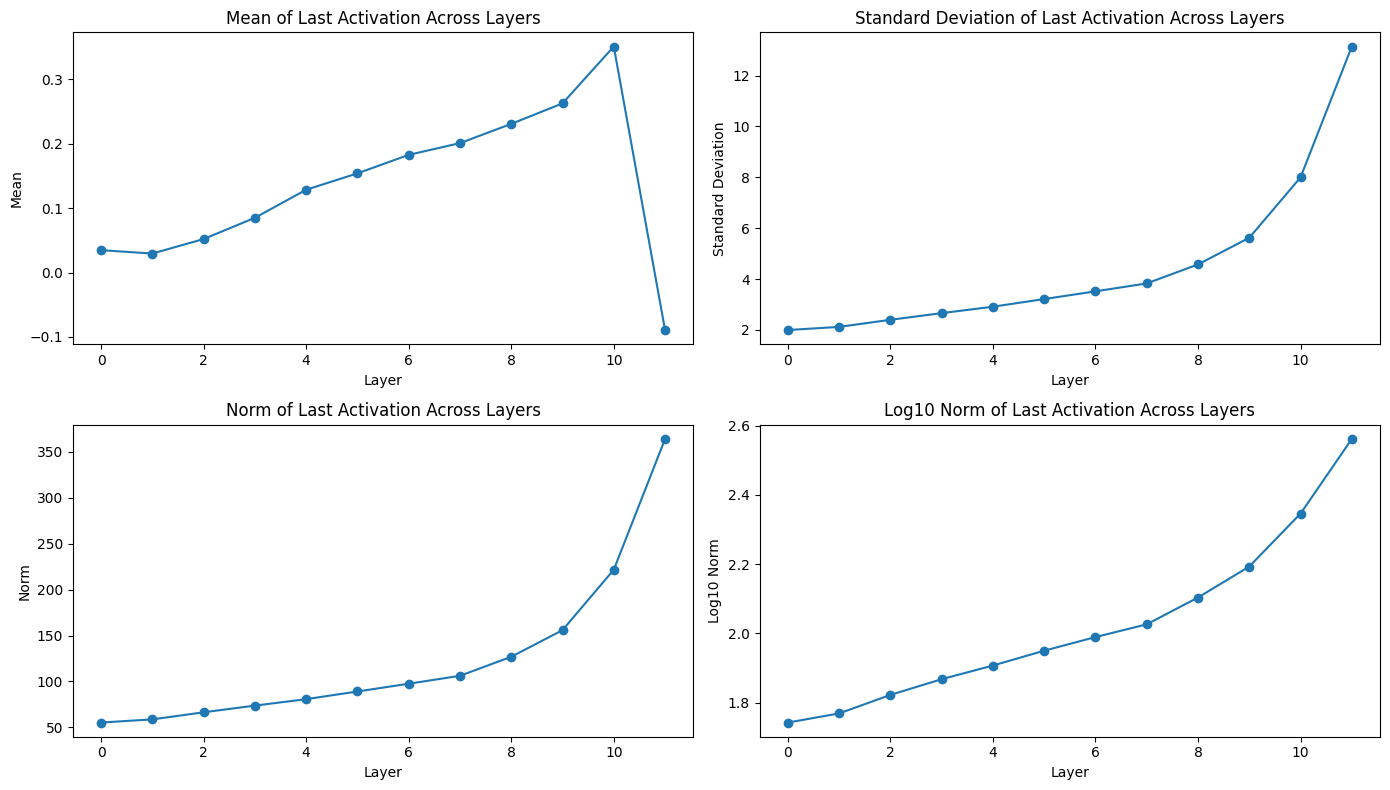

In [34]:
import matplotlib.pyplot as plt
#model = AutoModelForCausalLM.from_pretrained('gpt2').to('cpu')
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#model.tokenizer = tokenizer
activations_prompt="|<endoftext>|M"
steering_inputs = model.tokenizer(activations_prompt, return_tensors="pt")
print(len(steering_inputs['input_ids'][0]))
mean_values = []
std_values = []
norm_values = []
log10_norm_values = []

for layer in range(model.config.n_layer):
    layers_positions = {layer: [range(len(steering_inputs['input_ids'][0]))]}
    activations = get_activations(model, steering_inputs, layers_positions, get_at="end")
    enhanced_hook_activation_to_add = activations[layer][0].squeeze(0)

    # Calculate statistics
    mean_val = torch.mean(enhanced_hook_activation_to_add[-1]).item()
    std_val = torch.std(enhanced_hook_activation_to_add[-1]).item()
    norm_val = torch.norm(enhanced_hook_activation_to_add[-1]).item()
    log10_norm_val = torch.log10(torch.norm(enhanced_hook_activation_to_add[-1])).item()

    # Append statistics to lists
    mean_values.append(mean_val)
    std_values.append(std_val)
    norm_values.append(norm_val)
    log10_norm_values.append(log10_norm_val)

    # Print values
    print(f"Layer {layer} Activation[-1] Mean: {mean_val:.4f}")
    print(f"Layer {layer} Activation[-1] Std: {std_val:.4f}")
    print(f"Layer {layer} Activation[-1] Norm: {norm_val:.4f}")
    print(f"Layer {layer} Activation[-1] Log10Norm: {log10_norm_val:.4f}")

layers = list(range(model.config.n_layer))

plt.figure(figsize=(14, 8))

# Plotting mean values
plt.subplot(2, 2, 1)
plt.plot(layers, mean_values, marker='o', linestyle='-')
plt.title('Mean of Last Activation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Mean')

# Plotting standard deviation values
plt.subplot(2, 2, 2)
plt.plot(layers, std_values, marker='o', linestyle='-')
plt.title('Standard Deviation of Last Activation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Standard Deviation')

# Plotting norms
plt.subplot(2, 2, 3)
plt.plot(layers, norm_values, marker='o', linestyle='-')
plt.title('Norm of Last Activation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Norm')

# Plotting log10 norms
plt.subplot(2, 2, 4)
plt.plot(layers, log10_norm_values, marker='o', linestyle='-')
plt.title('Log10 Norm of Last Activation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Log10 Norm')

plt.tight_layout()
plt.show()



In [395]:
model = GPT2Helper('gpt2', device)

activations_prompt="Love"
layer=6
key_token_offset=1
model.reset_all()
tokens = model.tokenizer.encode(activations_prompt, return_tensors="pt")[0].unsqueeze(0)
out = model.get_logits(tokens)
wrapper_activation_to_add = model.get_last_activations(layer)
print(f"Activation Size Pre: {wrapper_activation_to_add.size()}")
wrapper_activation_to_add = wrapper_activation_to_add[0, -key_token_offset, :].detach().cpu().unsqueeze(0)
print(f"Activation Size Now: {wrapper_activation_to_add.size()}")
#print(f"Cosine sim: {cosine_similarity([enhanced_hook_activation_to_add[-1]],[wrapper_activation_to_add[-1]])}")

activations_prompt="Ball"
model.reset_all()
tokens = model.tokenizer.encode(activations_prompt, return_tensors="pt")[0].unsqueeze(0)
out = model.get_logits(tokens)
wrapper_activation_to_sub = model.get_last_activations(layer)
print(f"Activation Size Pre: {wrapper_activation_to_sub.size()}")
wrapper_activation_to_sub = wrapper_activation_to_sub[0, -key_token_offset, :].detach().cpu().unsqueeze(0)
#print(f"Cosine sim: {cosine_similarity([wrapper_activation_to_sub[-1]],[enhanced_hook_activation_to_sub[-1]])}")
print(f"Cosine sim: {cosine_similarity([wrapper_activation_to_sub[-1]],[wrapper_activation_to_add[-1]])}")

#increase output columns to see more of the activations
torch.set_printoptions(profile="full")

print("Love: ", wrapper_activation_to_add[-1,:10])
print("Ball: ", wrapper_activation_to_sub[-1,:10])
#print("Love: ", enhanced_hook_activation_to_add[-1,-8:])
#print("Ball: ", enhanced_hook_activation_to_sub[-1,-8:])


/Users/christopherackerman/repos/activation_additions_hf/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Activation Size Pre: torch.Size([1, 1, 768])
Activation Size Now: torch.Size([1, 768])
Activation Size Pre: torch.Size([1, 1, 768])
Cosine sim: [[0.999972]]
Love:  tensor([-0.3711, -0.9688,  0.3613, -0.4453,  0.9844,  0.0688,  2.1250, -1.3359,
        -0.5859, -0.7656], dtype=torch.bfloat16)
Ball:  tensor([ 0.1465, -2.4375,  0.9805, -0.5391,  1.2812, -0.4434, -0.0435, -2.6094,
        -1.6172, -0.0027], dtype=torch.bfloat16)


In [16]:
for name, param in model.named_parameters():
    if '.'.join(name.split('.')[-2:]) in ['wte.weight','wpe.weight','c_proj.weight','c_proj.bias']:
        param.data -= param.data.mean()
        print(name, param.data.mean(), param.size())

transformer.wte.weight tensor(-1.0121e-10) torch.Size([50257, 768])
transformer.wpe.weight tensor(3.8805e-11) torch.Size([1024, 768])
transformer.h.0.attn.c_proj.weight tensor(-1.0348e-10) torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias tensor(-3.1044e-10) torch.Size([768])
transformer.h.0.mlp.c_proj.weight tensor(5.1902e-10) torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias tensor(-3.1044e-10) torch.Size([768])
transformer.h.1.attn.c_proj.weight tensor(6.3705e-10) torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias tensor(7.7610e-10) torch.Size([768])
transformer.h.1.mlp.c_proj.weight tensor(-1.4875e-10) torch.Size([3072, 768])
transformer.h.1.mlp.c_proj.bias tensor(-6.2088e-10) torch.Size([768])
transformer.h.2.attn.c_proj.weight tensor(-1.2903e-09) torch.Size([768, 768])
transformer.h.2.attn.c_proj.bias tensor(-7.7610e-11) torch.Size([768])
transformer.h.2.mlp.c_proj.weight tensor(3.7350e-10) torch.Size([3072, 768])
transformer.h.2.mlp.c_proj.bias tensor(-1.2418e-0

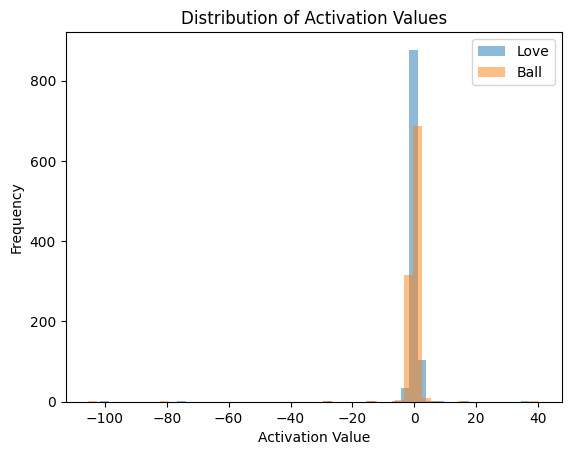

In [402]:
import matplotlib.pyplot as plt

plt.hist(enhanced_hook_activation_to_add.numpy().flatten(), bins=50, alpha=0.5, label='Love')
plt.hist(enhanced_hook_activation_to_sub.numpy().flatten(), bins=50, alpha=0.5, label='Ball')
plt.legend(loc='upper right')
plt.title('Distribution of Activation Values')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()


In [404]:
thresh=10
print("Love: ", torch.sum(torch.abs(enhanced_hook_activation_to_add) > thresh))
print("Ball: ", torch.sum(torch.abs(enhanced_hook_activation_to_sub) > thresh))
print("Love: ", enhanced_hook_activation_to_add.shape)
print("Ball: ", enhanced_hook_activation_to_sub.shape)
#get their indices
print("Love: ", torch.nonzero(torch.abs(enhanced_hook_activation_to_add[0]) > thresh))
print("Ball: ", torch.nonzero(torch.abs(enhanced_hook_activation_to_sub[0]) > thresh))


Love:  tensor(6)
Ball:  tensor(6)
Love:  torch.Size([1, 1024])
Ball:  torch.Size([1, 1024])
Love:  tensor([[  9],
        [238],
        [268],
        [373],
        [428],
        [994]])
Ball:  tensor([[  9],
        [238],
        [268],
        [373],
        [428],
        [994]])


In [32]:
print(model.config)

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.40.2",
  "use_cache": true,
  "vocab_size": 50257
}



In [31]:
model.tokenizer.eos_token

'<|endoftext|>'